<a href="https://colab.research.google.com/github/nishikalewis/cs666student/blob/main/Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

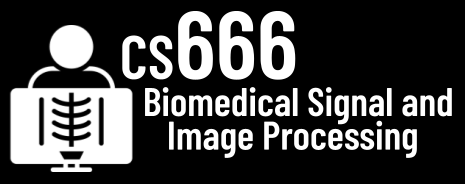
# Assignment 6

In [ ]:
# NAME: Nishika Divya Lewis

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [9]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 02:42:49--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz’

mito.npz            100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-25 02:42:50 (260 MB/s) - ‘mito.npz’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [10]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

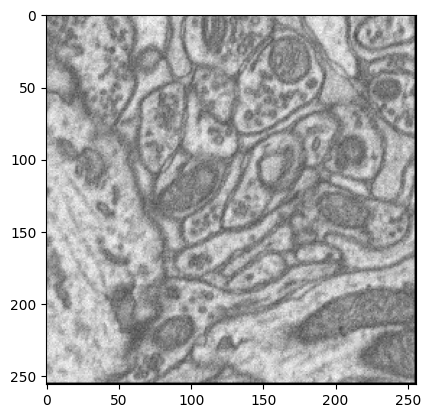

In [11]:
# TODO: Show the first image with the gray colormap.
plt.imshow(images[0],cmap = 'gray')

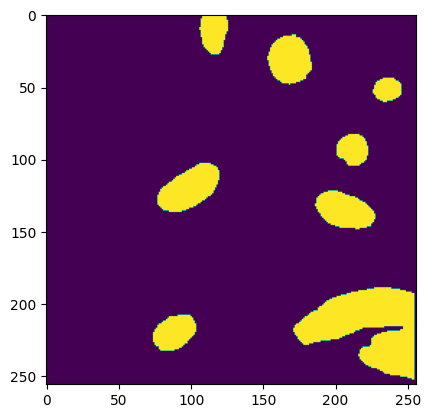

In [12]:
# TODO: Show the first mask.
plt.imshow(masks[0])

## 1. SAM in AUTO mode (15 points)

In [13]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=832b72b8646eb31330c9c7a3dfc8378b0f55fbed594fd88075023459a924f8eb
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built metas

In [14]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [15]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [16]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


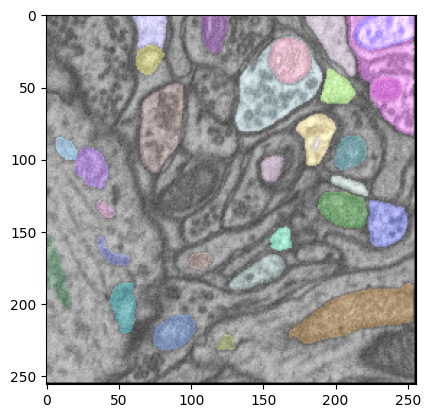

In [17]:
imshow( mh.imread('first_output.png') )

In [18]:
# TODO: Does SAM work well for mitochondria detection?
# Based on the previous image, it appears that SAM detects mitochondria adequately, although it may be improved; I presume this is due to the image's low resolution.

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# TODO: 
results = SegAutoMaskPredictor().image_predict(
    source="nervecell.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


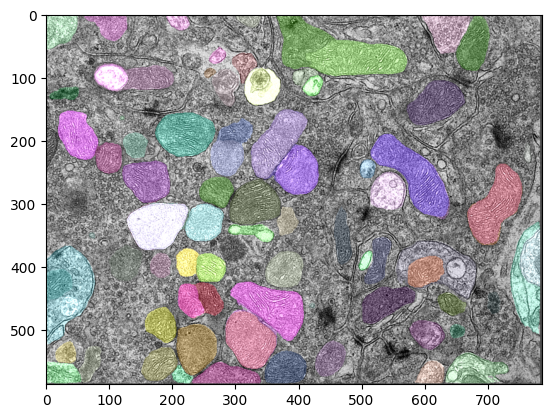

In [21]:
imshow(mh.imread('second_output.png') )

In [ ]:
# TODO: Does SAM work well on your example?
# TODO: SAM works well with my example, I believe it's because the image has better resolution when compared to first_png.

## 2. Train a U-Net classifier from scratch (50 points)


In [23]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


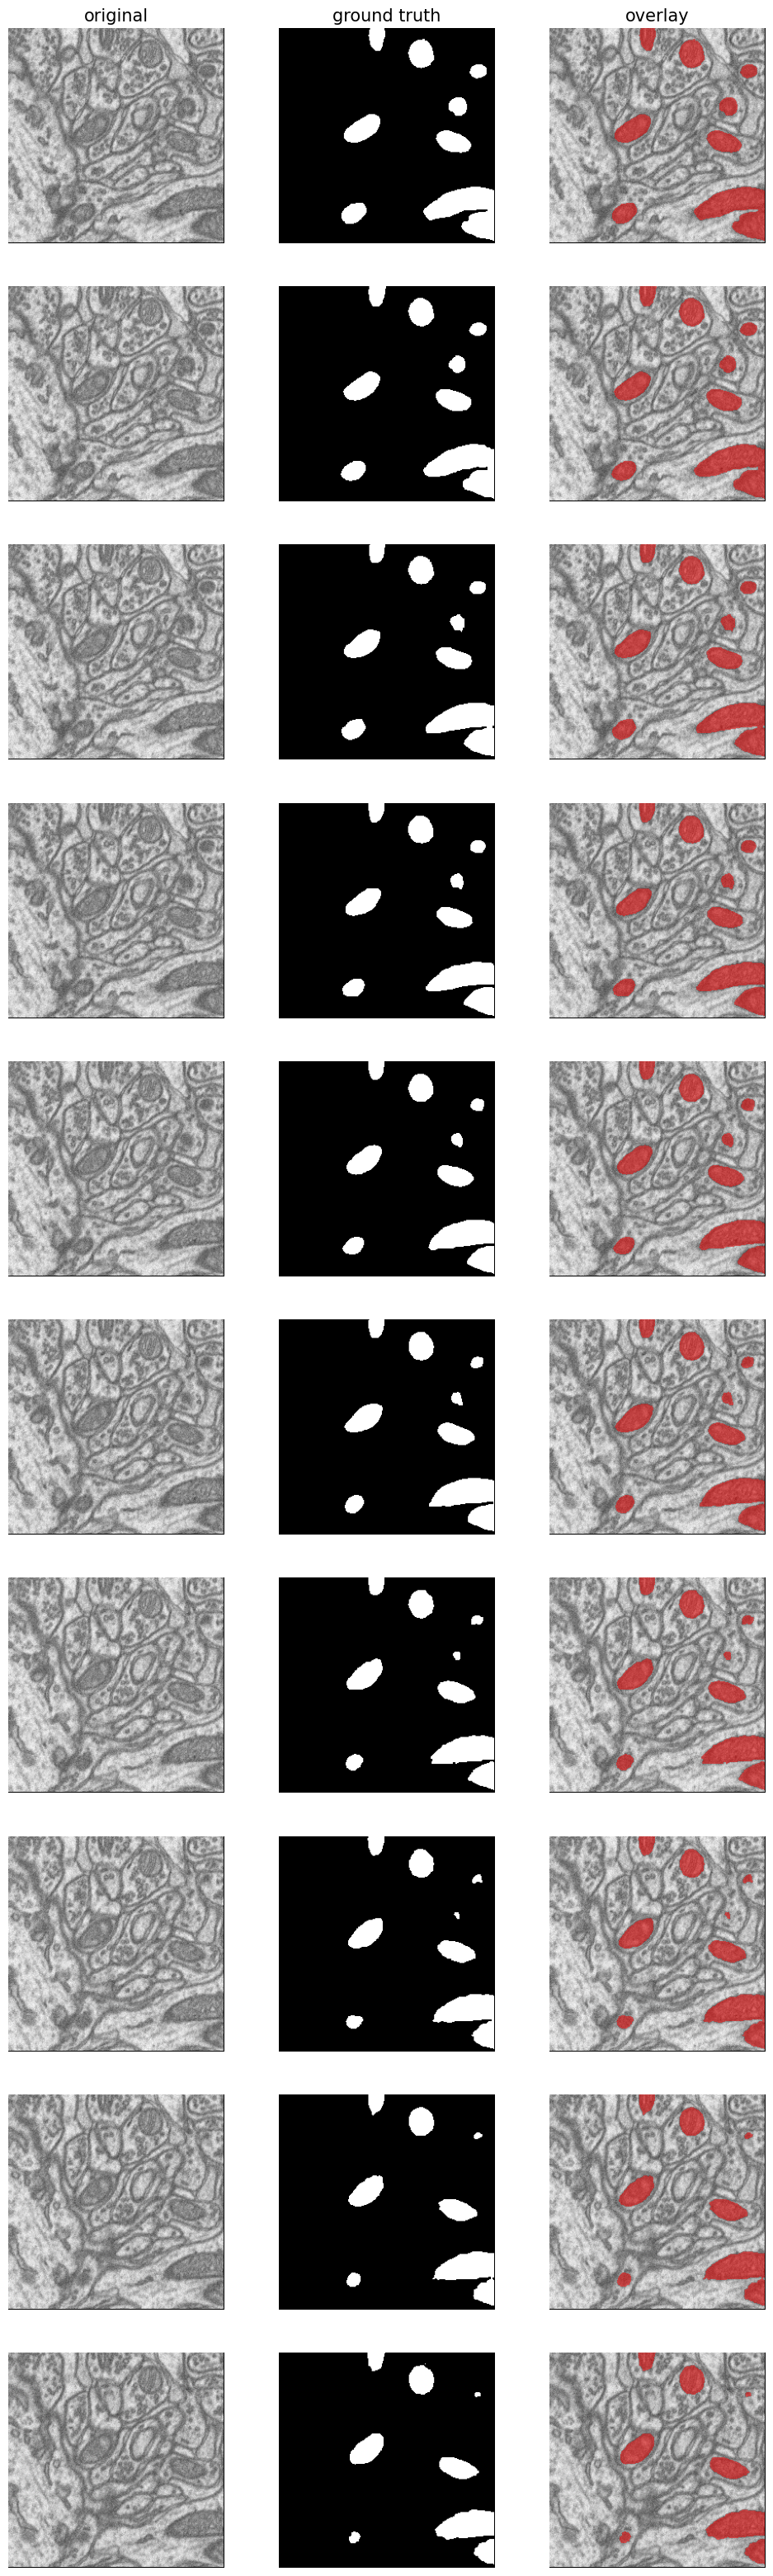

In [25]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [26]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [27]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
X = images.astype(float32)
X=X/243.0 
X=X.reshape((660, 256, 256, 1))

In [28]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [29]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [30]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
y = masks.astype(bool)
y=y.reshape((660, 256, 256, 1)) 

In [31]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [32]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [35]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [36]:
# TODO: Why do we call train_test_split twice?
#First split - to train, test 
#second split- to train again into validation and train set.

In [37]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# It is runtime data augmentation which has image flip and setting the rotation metrics.

(2, 256, 256, 1) (2, 256, 256, 1)


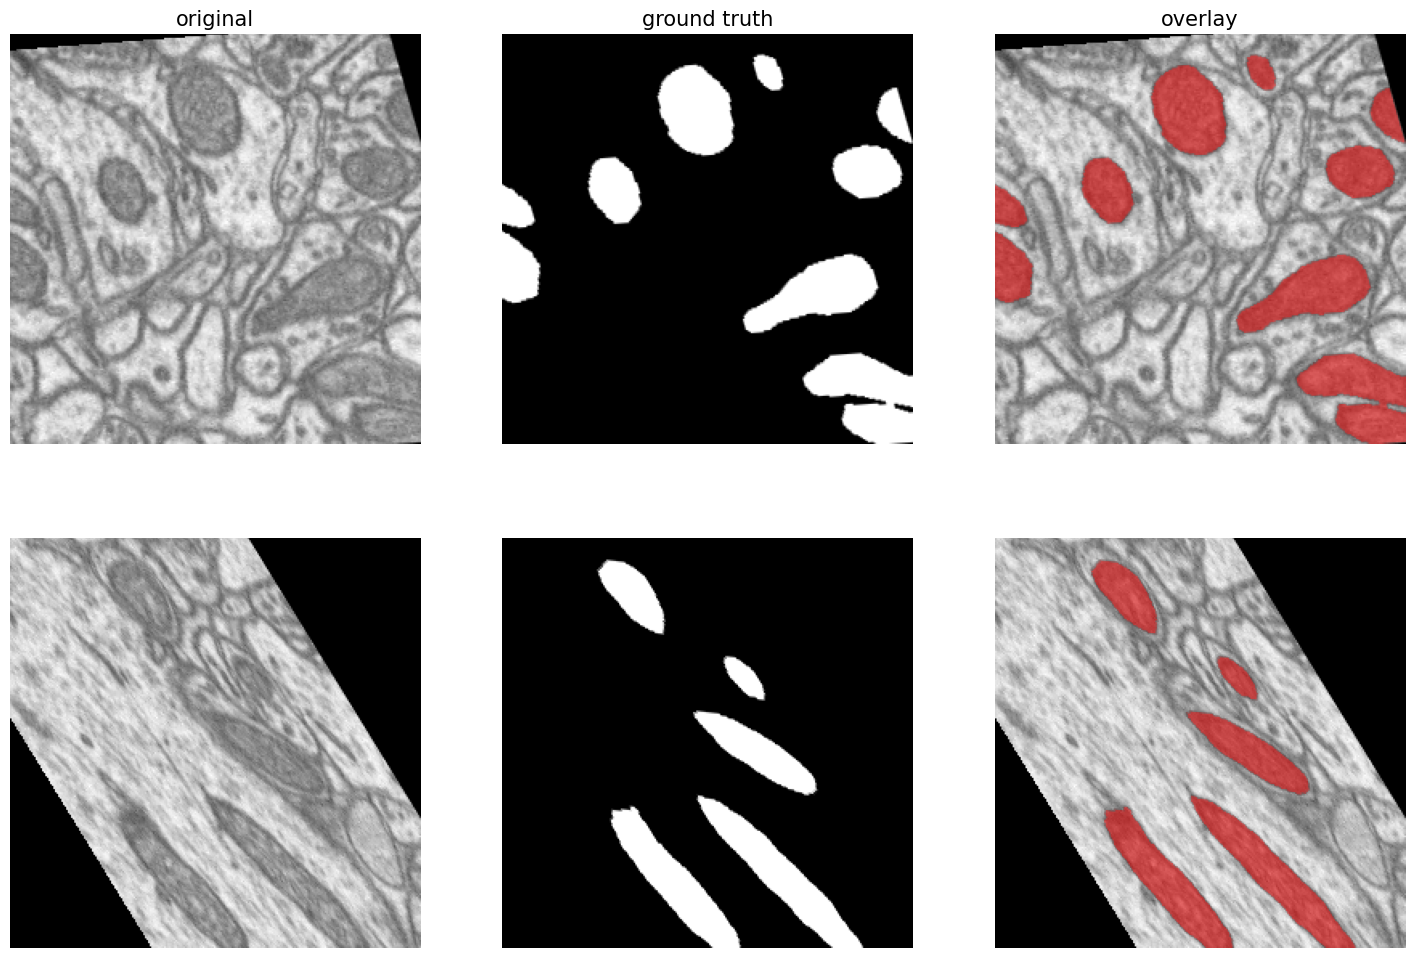

In [38]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [39]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [40]:
# TODO: How many  trainable parameters does the model use?
# 31,030,593
print(model.count_params())
#model.summary()

31030593


In [41]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [42]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# It is a evaluation metric for image segmentation. 
# To evaluate a model using the IoU metric, the requirements are- 
#The ground truth annotation ( masks);
#And the model’s predictions.

In [43]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#

EPOCHS=30
train_batches=train_gen
STEPS_PER_EPOCH=len(X_train)
history = model.fit(
train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_data=(X_val, y_val))

Epoch 1/30
369/369 [==============================] - 109s 270ms/step - loss: 0.2315 - iou: 0.0582 - iou_thresholded: 2.1282e-04 - val_loss: 0.2113 - val_iou: 0.1187 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 59s 160ms/step - loss: 0.1669 - iou: 0.1458 - iou_thresholded: 0.0712 - val_loss: 0.1522 - val_iou: 0.2742 - val_iou_thresholded: 0.4239
Epoch 3/30
369/369 [==============================] - 58s 158ms/step - loss: 0.1301 - iou: 0.2669 - iou_thresholded: 0.3335 - val_loss: 0.1006 - val_iou: 0.4393 - val_iou_thresholded: 0.5504
Epoch 4/30
369/369 [==============================] - 59s 159ms/step - loss: 0.0962 - iou: 0.3816 - iou_thresholded: 0.4538 - val_loss: 0.0844 - val_iou: 0.5375 - val_iou_thresholded: 0.6545
Epoch 5/30
369/369 [==============================] - 59s 161ms/step - loss: 0.0816 - iou: 0.4581 - iou_thresholded: 0.5510 - val_loss: 0.0836 - val_iou: 0.4703 - val_iou_thresholded: 0.7094
Epoch 6/30
369/369 [================

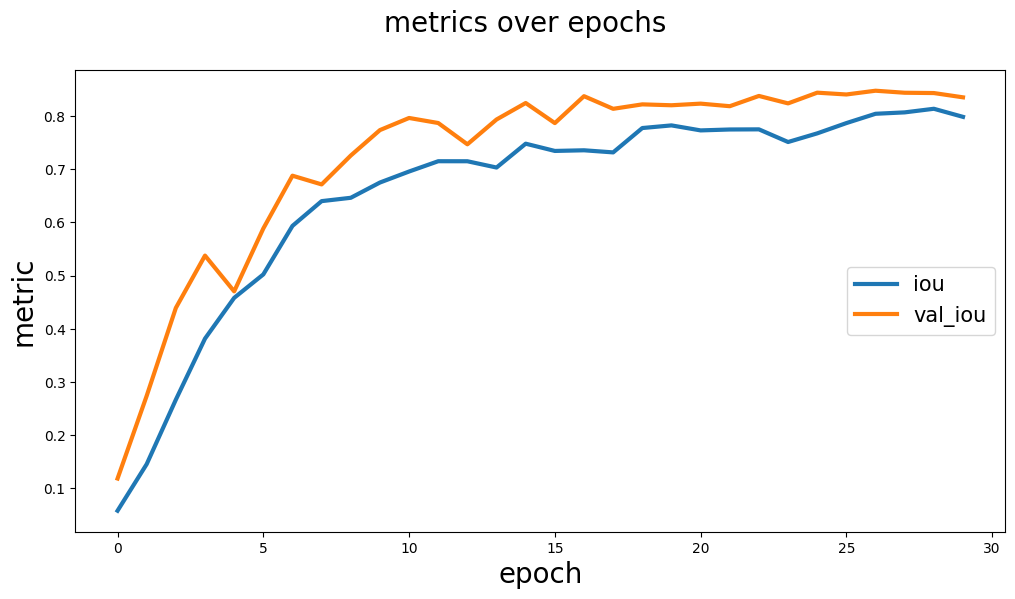

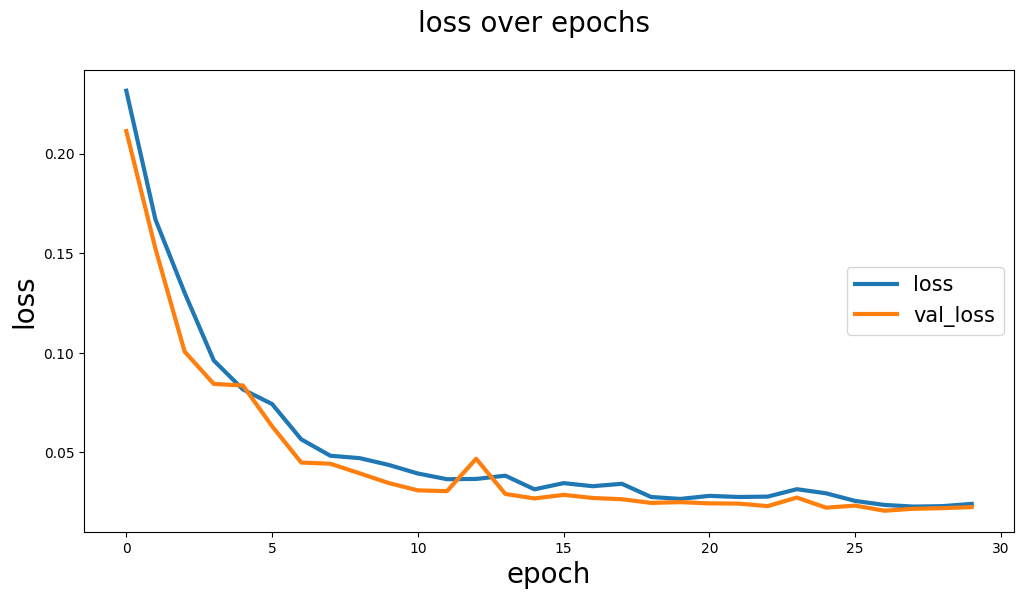

In [46]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [47]:
# TODO: Do these plots look good to you?
# The plots look good. We can clearly see that the loss is decreased with the change in epoch. 
# Also, the IOU values increase with the change.

## 3. Evaluate U-Net (10 points)

In [48]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


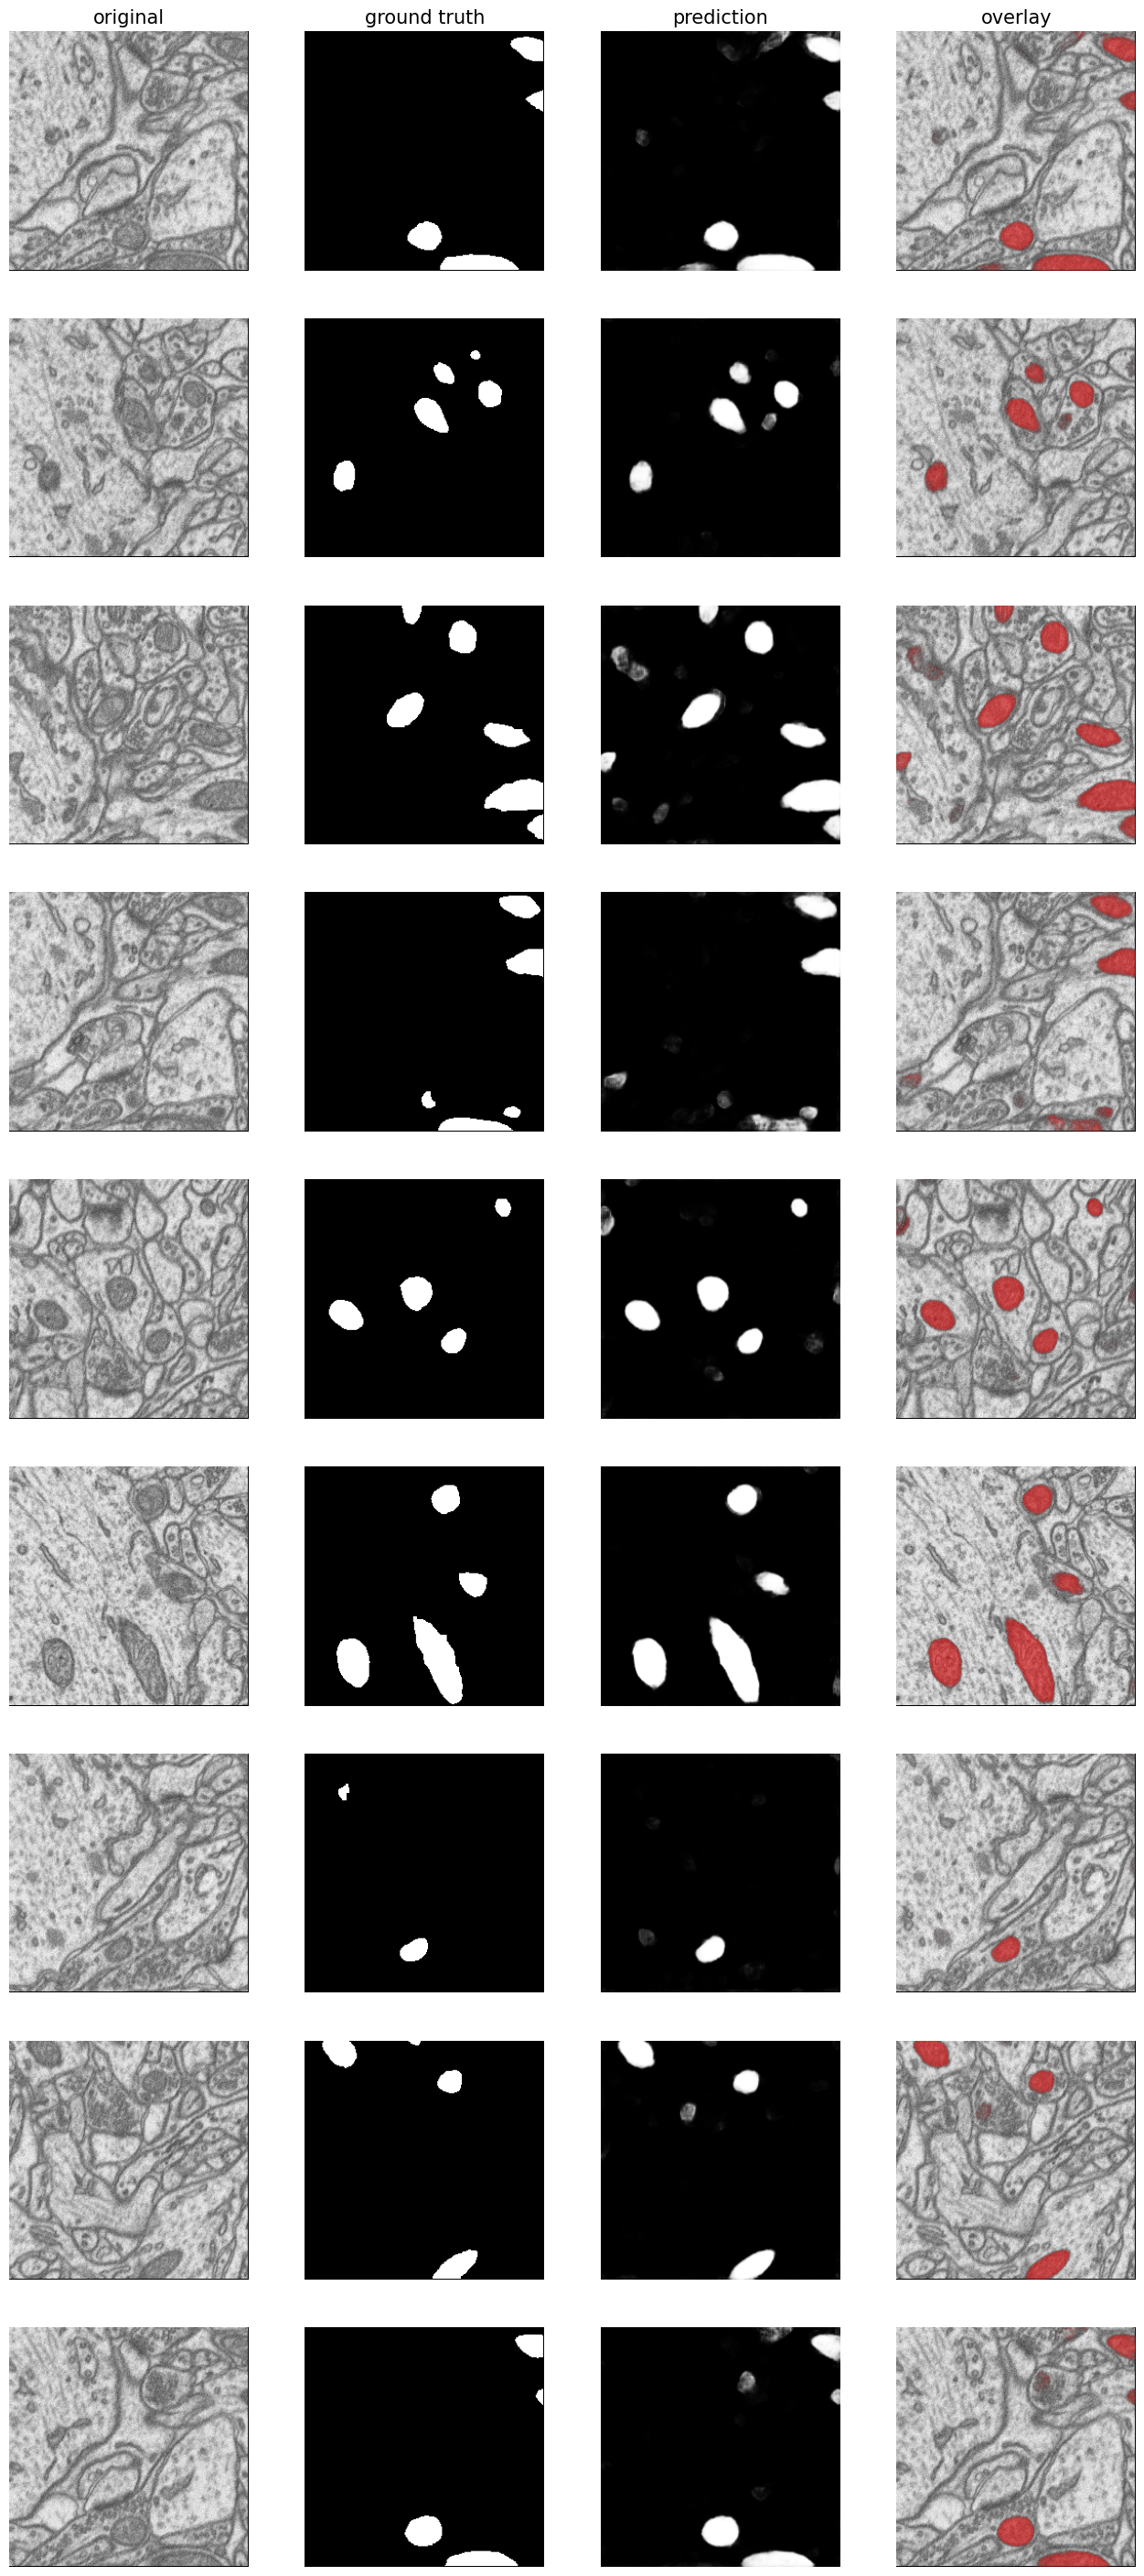

In [49]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [50]:
import sklearn.metrics

In [51]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8943098941344263

In [53]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# Jaccard score is defined as the size of the intersection divided by the size of the union of two label sets, 
# is used to compare set of predicted labels for a sample to the corresponding set of labels in ground truth lables.
# IoU = Area of INTERSECTION /Area of UNION. IoU score ≥0.5 is considered as good.

In [54]:
# TODO: Did the U-Net perform well on X_test?
# Yes the U-Net performed well on X_test.

## 4. Combine U-Net with SAM (10 points)

In [55]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [56]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [57]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [58]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [59]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [60]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  # the image format is converted to a np int type and the range is changed.
  # then the image is saved.

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)
  pred, _ = mh.labeled.label(pred)
  # This is the code for setting threshold value to 0.5 to make binary predictions.
  # the positive predictions will have true value and the negative predictions will have false value.

  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)
  # labels the segmented regions in pred

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)
  # it takes labeled regions and returns tuples with bounding boxes.

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  #SegManualMaskPredictor class to make predictions on an image, using a model of type "vit_l" to return masks for the given image. 

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)
  # combining the sam and U-net model

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  # saving the masks to y_pred array

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [61]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8943098941344263

In [62]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8611806351164772

In [63]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# the score from U-net is a bit more when compared to the score U-net+ SAM performance.

## Bonus: Improve the results. (33 points)

In [64]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.
# a higher threshold can result in a more higher jaccred score.
# Changing the threshold can affect the intersection and union between the predicted and masks.

In [67]:
# TODO: 


In [ ]:
# in collaboration with Samhitha Medi

#Reference links-

#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
#https://www.tensorflow.org/tutorials/images/segmentation#train_the_model
#https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union#:~:text=To%20define%20the%20term%2C%20in,matches%20the%20ground%20truth%20data.
#https://keras.io/examples/vision/oxford_pets_image_segmentation/
#https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/#
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#